In [1]:
import os
import shutil
import random
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GaussianNoise, GlobalMaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import (
    cohen_kappa_score, matthews_corrcoef, roc_auc_score, log_loss,
    precision_score, recall_score, f1_score, confusion_matrix
)
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Loading Images and Labels

In [2]:
# Paths
train_dir = '/Users/sukanya/Documents/Alziemers Multi Modal/Split Dataset/train'  
test_dir = '/Users/sukanya/Documents/Alziemers Multi Modal/Split Dataset/test' 

In [3]:
#  Loading images and label
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    shuffle=True
)

Found 795 files belonging to 4 classes.
Found 201 files belonging to 4 classes.


In [4]:
# Class Names
class_names = train_dataset.class_names
print("Class names:", class_names)

Class names: ['Mild Dementia', 'Moderate Dementia', 'No Dementia', 'Severe Dementia ']


## Normalizing Images

In [5]:
# Normalize the image data
normalization_layer = layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [6]:
input_shape = (256, 256, 3)

# MobileNetV2 For Image Classification

In [7]:
# Base Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

base_model = MobileNetV2(weights='imagenet', include_top=False)
base_model.trainable = False

In [8]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.25)(x)
predictions = layers.Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[:100]:
    layer.trainable = False

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[0][0]']        

In [10]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [11]:
# Training the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10
)

Epoch 1/10
25/25 [==============================] - 6s 218ms/step - loss: 0.9847 - accuracy: 0.6528 - val_loss: 0.5793 - val_accuracy: 0.8259
Epoch 2/10
25/25 [==============================] - 5s 197ms/step - loss: 0.4406 - accuracy: 0.8704 - val_loss: 0.3260 - val_accuracy: 0.9204
Epoch 3/10
25/25 [==============================] - 5s 196ms/step - loss: 0.2375 - accuracy: 0.9572 - val_loss: 0.1710 - val_accuracy: 0.9602
Epoch 4/10
25/25 [==============================] - 5s 197ms/step - loss: 0.1373 - accuracy: 0.9786 - val_loss: 0.1148 - val_accuracy: 0.9751
Epoch 5/10
25/25 [==============================] - 5s 196ms/step - loss: 0.0956 - accuracy: 0.9925 - val_loss: 0.0868 - val_accuracy: 0.9900
Epoch 6/10
25/25 [==============================] - 5s 197ms/step - loss: 0.0721 - accuracy: 0.9937 - val_loss: 0.0570 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 6s 225ms/step - loss: 0.0480 - accuracy: 0.9975 - val_loss: 0.0501 - val_accuracy: 1.0000
Epoch 

## Model Metrics

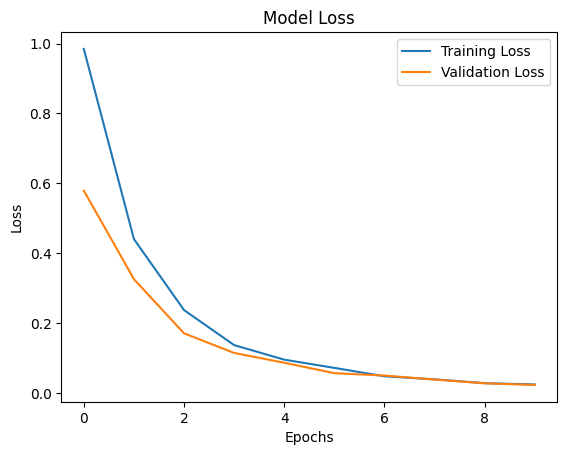

In [12]:
# Training & validation loss 
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

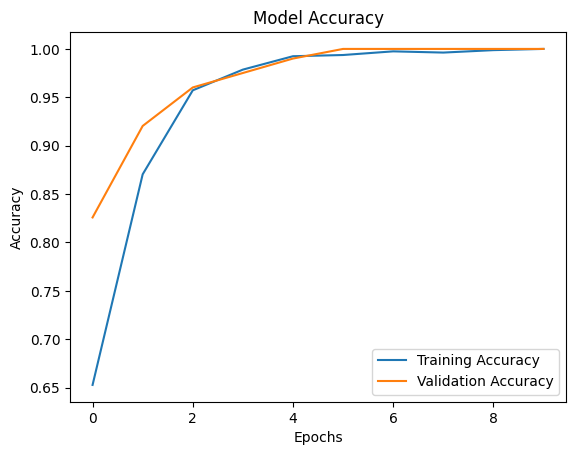

In [13]:
# Training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [14]:
# Metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss}")
print(f"Final Validation Loss: {final_val_loss}")
print(f"Final Training Accuracy: {final_train_acc}")
print(f"Final Validation Accuracy: {final_val_acc}")

Final Training Loss: 0.024670621380209923
Final Validation Loss: 0.023334544152021408
Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


7/7 [==============================] - 1s 143ms/step


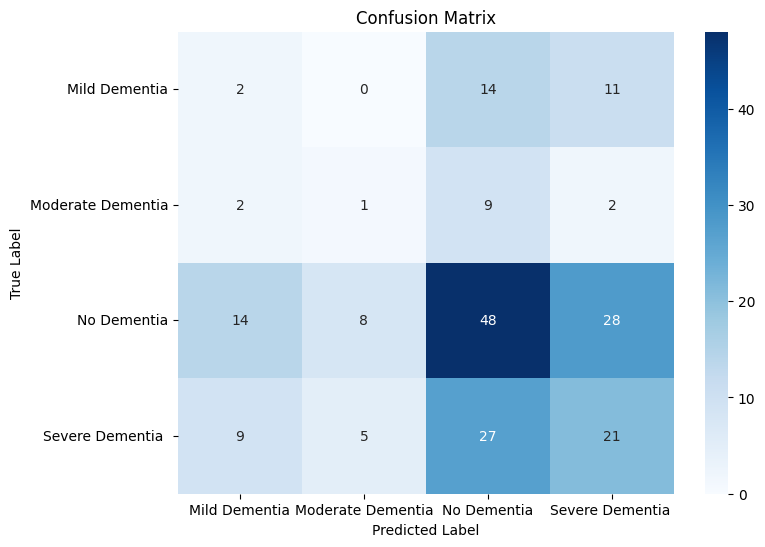

In [15]:
# Confusion Matrix
y_pred = np.argmax(model.predict(test_dataset), axis=-1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()